In [1]:
import numpy as np
import scipy.optimize as spopt
import pandas as pd

import matplotlib.pyplot as plt 
import os

In [2]:
def MagneticLenght (IntegratedMagneticField, CentralMagneticField):
    magnetic_lenght = IntegratedMagneticField / CentralMagneticField
    return magnetic_lenght

In [3]:
def LinearLaw (x, a, b):
    y = a*x + b
    return y

In [26]:
def MagneticRigidity (check):
    i = 2
    df = pd.read_csv("/eos/home-r/russogi/WINDOWS/Desktop/AD_ELENA_scripts_data/AD_MagneticModel/MagneticRigidity.csv")
    Magnetic_Rigidity = df.Brho.values[i]
    Momentum = df.p.values[i]
    return Magnetic_Rigidity, Momentum

In [27]:
BRHO, BeamMomentum = MagneticRigidity(1)
print(BRHO, "Tm --> which corresponds to p = ", BeamMomentum, "GeV/c which is an approx of ", BRHO*2.998e8/(1e9))

1.00068 Tm --> which corresponds to p =  0.3 GeV/c which is an approx of  0.300003864


## Get subdirectories in dipoles folder

In [28]:
dipoles_directory_path = "/eos/home-r/russogi/WINDOWS/Desktop/AD_ELENA_scripts_data/AD_MagneticModel/dipoles/"

dipoles_families = os.listdir(dipoles_directory_path)[2:2+3]
print(dipoles_families)

['BHN', 'BHS', 'BHW']


In [29]:
MadxNominalAngle = 0.2457993878

/eos/home-r/russogi/WINDOWS/Desktop/AD_ELENA_scripts_data/AD_MagneticModel/dipoles/BHN
0 central_field_PXMBHHGWWP.csv
1 int_field_PXMBHHGWWP.csv


/cvmfs/sft.cern.ch/lcg/views/LCG_102b_nxcals_pro_pytimber_pro/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


/eos/home-r/russogi/WINDOWS/Desktop/AD_ELENA_scripts_data/AD_MagneticModel/dipoles/BHS
0 central_field_PXMBHHHWWP.csv
1 int_field_PXMBHHHWWP.csv
/eos/home-r/russogi/WINDOWS/Desktop/AD_ELENA_scripts_data/AD_MagneticModel/dipoles/BHW
0 central_field_PXMBHHFHWP.csv
1 int_field_PXMBHHFHWP.csv


/cvmfs/sft.cern.ch/lcg/views/LCG_102b_nxcals_pro_pytimber_pro/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_nxcals_pro_pytimber_pro/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


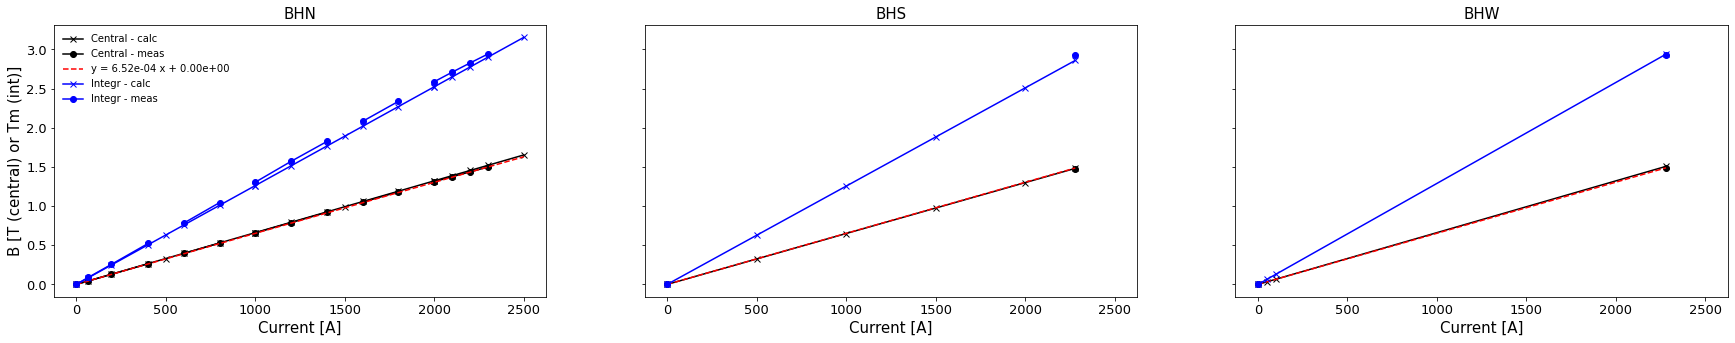

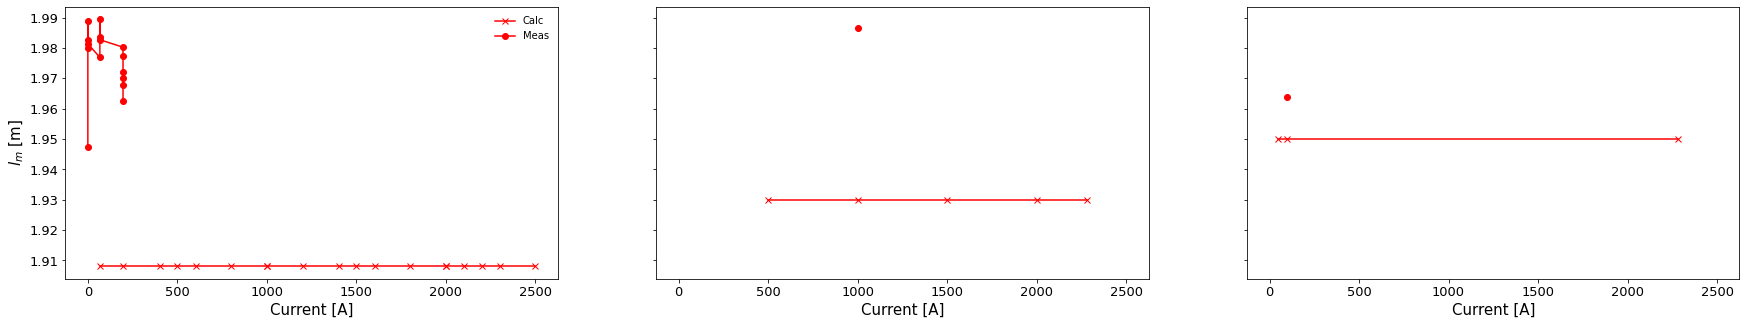

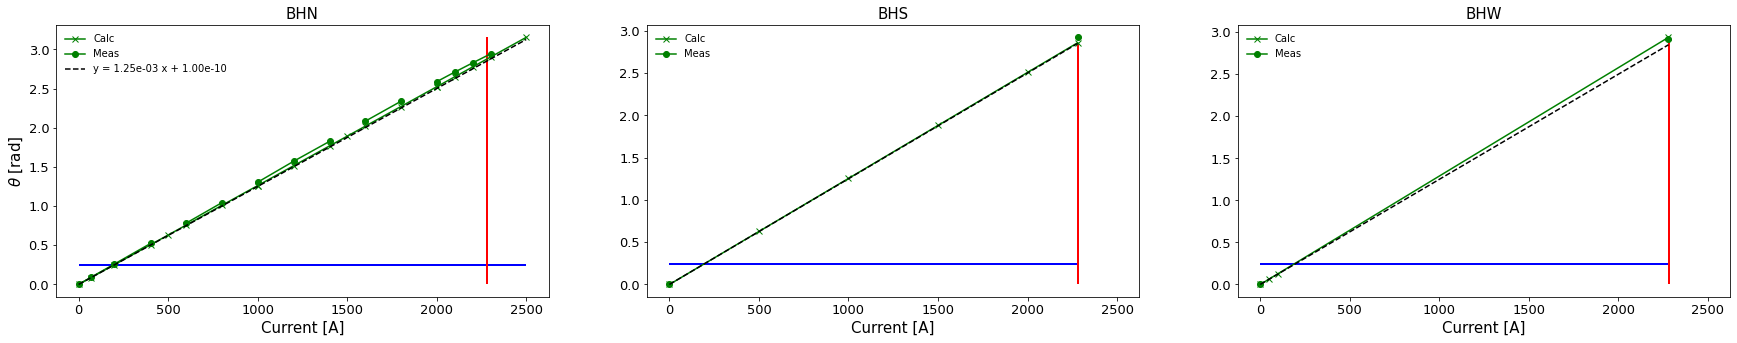

In [38]:
f, ax = plt.subplots(1, len(dipoles_families), figsize = (30,5), sharex = True, sharey = True)
f1, ax1 = plt.subplots(1, len(dipoles_families), figsize = (30,5), sharex = True, sharey = True)
f2, ax2 = plt.subplots(1, len(dipoles_families), figsize = (30,5), sharex = True, sharey = False)

for i, dipole in enumerate(dipoles_families):
    DipolesData = pd.DataFrame()
    FitDipolesMagneticCurves = pd.DataFrame()
    
    FilesInFolder = os.listdir(dipoles_directory_path + str("%s"%dipole))
    os.chdir(dipoles_directory_path + str("%s"%dipole))
    print(dipoles_directory_path + str("%s"%dipole))
        
    # get central and integral field for every magnet family
    for h, file in enumerate(FilesInFolder):
        if 'central' in str(file):
            print(h, file)
            df = pd.read_csv("%s"%file)
            Current_CentralField = df.Current
            CentralField_Calc = df.Calculated
            try:
                CentralField_Measured = df.MMdata
            except AttributeError:
                CentralField_Measured = np.zeros(len(CentralField_Calc)) * np.nan
                print("No measurements done on the central field for this magnet family")
        elif 'int' in str(file):
            print(h, file)
            df = pd.read_csv("%s"%file)
            Current_IntField = df.Current
            IntField_Calc = df.Calculated
            try:
                IntField_Measured = df.MMdata
            except AttributeError:
                IntField_Measured = np.zeros(len(IntField_Measured)) * np.nan
                print("No measurements done on the integrated field for this magnet family")
                
    #calculation MAGNETIC LENGHT            
    ML_Calculated = MagneticLenght(IntField_Calc.dropna(), CentralField_Calc.dropna())
    try:
        ML_Measured = MagneticLenght(IntField_Measured.dropna(), CentralField_Measured.dropna())
    except AttributeError:
        ML_Measured = MagneticLenght(IntField_Measured, CentralField_Measured)
    #calculation NORMALISED QUADRUPOLAR STRENGHT
    K0_dipole_calc = CentralField_Calc / BRHO  #it is in 1/m
    BendingAngle_calc = IntField_Calc / BRHO # this is the angle in radiants
    K0_dipole_meas = CentralField_Measured / BRHO  #it is in 1/m
    BendingAngle_meas = IntField_Measured / BRHO # this is the angle in radiants

    opt_coeff_linear , opt_covar_linear = spopt.curve_fit(LinearLaw, Current_CentralField, BendingAngle_meas, 
                                                          p0 = [1.25e-3, 1e-10], check_finite = False)
    #high energy 1.93e-4; 100MeV/c coeff = 3.8e-3, at 300MeV/c coeff = 1.25e-3
    if i == 0:
        opt_coeff_Bfield , opt_covar_Bfield = spopt.curve_fit(LinearLaw, Current_CentralField, CentralField_Measured, 
                                                              p0 = [6.52e-4, 0.], check_finite = False)
    elif i == 2:
        opt_coeff_Bfield , opt_covar_Bfield = spopt.curve_fit(LinearLaw, Current_CentralField, CentralField_Measured, 
                                                              p0 = [6.531e-4, 0.], check_finite = False)
    
    #Central field plot
    ax[i].plot(Current_CentralField, CentralField_Calc, "x-k", label = "Central - calc")
    ax[i].plot(Current_CentralField, CentralField_Measured, "o-k", label = "Central - meas")
    ax[i].plot(Current_CentralField, LinearLaw(Current_CentralField, *opt_coeff_Bfield), "--r",label = "y = %1.2e x + %1.2e"%(opt_coeff_Bfield[0], opt_coeff_Bfield[1]))
    
    #Integrated field plot
    ax[i].plot(Current_IntField, IntField_Calc, "x-b", label = "Integr - calc")
    ax[i].plot(Current_IntField, IntField_Measured, "o-b", label = "Integr - meas")
    #Features plot
    ax[i].set_xlabel ("Current [A]", size = 15)
    ax[i].tick_params (axis = "both", which = "major", labelsize = 13)
    ax[i].set_title("%s"%dipole, size = 15)
    
    #Plot magnetic lenght
    ax1[i].plot(Current_CentralField, ML_Calculated, "x-r", label = "Calc")
    try:
        ax1[i].plot(Current_CentralField.iloc[IntField_Measured.dropna()], ML_Measured, "o-r", label = "Meas")
    except ValueError:
        pass
    #Features plot
    ax1[i].set_xlabel ("Current [A]", size = 15)
    ax1[i].tick_params (axis = "both", which = "major", labelsize = 13)
    
    #plot normalised quad coefficient k1 [1/m^2]
    ax2[i].plot(Current_CentralField, BendingAngle_calc, "x-g", label = "Calc")
    ax2[i].plot(Current_CentralField, BendingAngle_meas, "o-g", label = "Meas")
    #add working point found in madx
    ax2[i].hlines(y = MadxNominalAngle, xmin = 0, xmax = max(Current_CentralField), ls = "-", color = "b", lw = 2)
    ax2[i].vlines(x = 2282.937, ymin = max(BendingAngle_calc), ymax = min(BendingAngle_calc), ls = "-", color = "r", lw = 2)
    ax2[i].legend(frameon = False)
    #Features plot
    ax2[i].set_xlabel ("Current [A]", size = 15)
    ax2[i].tick_params (axis = "both", which = "major", labelsize = 13)
    ax2[i].set_title("%s"%dipole, size = 15)
    # add fit
    ax2[i].plot(Current_CentralField, LinearLaw(Current_CentralField, *opt_coeff_linear), "--k", label = "y = %1.2e x + %1.2e"%(opt_coeff_linear[0], opt_coeff_linear[1]))
    
    DipolesData[str("Current")] = Current_CentralField
    DipolesData[str("Calculated")] = BendingAngle_calc
    DipolesData[str("Measured")] = BendingAngle_meas
    DipolesData.to_csv("/eos/home-r/russogi/WINDOWS/Desktop/AD_ELENA_scripts_data/AD_MagneticModel/dipoles/Dipole_%s_BendingAngle_%s_GeV.csv"%(dipole, str(BeamMomentum)), index = False)
    
    FitDipolesMagneticCurves["linear"] = opt_coeff_linear
    FitDipolesMagneticCurves.to_csv("/eos/home-r/russogi/WINDOWS/Desktop/AD_ELENA_scripts_data/AD_MagneticModel/dipoles/FIT_Dipoles_%s_AngleCurrent_%s_GeV.csv"%(dipole, str(BeamMomentum)), index = False)
    
ax[0].set_ylabel ("B [T (central) or Tm (int)]", size = 15)
ax[0].legend(frameon = False)

ax1[0].set_ylabel ("$l_m$ [m]", size = 15)
ax1[0].legend(frameon = False)

ax2[0].set_ylabel (r"$\theta$ [rad]", size = 15)
ax2[0].legend(frameon = False)

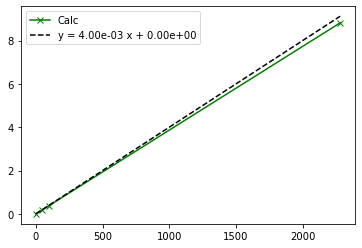

In [21]:
plt.plot(Current_CentralField, BendingAngle_calc, "x-g", label = "Calc")
opt_coeff_linear = [4e-3, 0]
plt.plot(Current_CentralField, LinearLaw(Current_CentralField, *opt_coeff_linear), "--k", label = "y = %1.2e x + %1.2e"%(opt_coeff_linear[0], opt_coeff_linear[1]))
plt.legend()